In [1]:
import pandas as pd
import numpy as np
import wfdb
import ast
from itertools import chain
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import acf
import os
import tqdm

### Загрузка данных

In [2]:
df = pd.read_csv('plt/ptbxl_database.csv')
df.head()

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


In [3]:
df['heart_axis'].value_counts(dropna=False)

NaN     8468
MID     7687
LAD     3764
ALAD    1382
RAD      221
ARAD     122
AXL      101
AXR       51
SAG        3
Name: heart_axis, dtype: int64

In [4]:
path = 'plt/records500'
example = wfdb.rdsamp(path + '/00000/00001_hr')

In [5]:
main_lines = example[0].T[:6]

In [6]:
example[0][:, :6].shape

(5000, 6)

### Свертка 6 отведений в 2 измерения

In [7]:
pca = PCA(n_components=2)
pca.fit(example[0][:, :6])

PCA(n_components=2)

In [8]:
np.sum(pca.explained_variance_ratio_)

0.9999901807685874

In [9]:
pca.components_.T

array([[ 0.60260166,  0.1352525 ],
       [ 0.41833954, -0.45408546],
       [-0.184295  , -0.58926638],
       [-0.51001382,  0.16150573],
       [ 0.39266456,  0.36370696],
       [ 0.11661501, -0.51953002]])

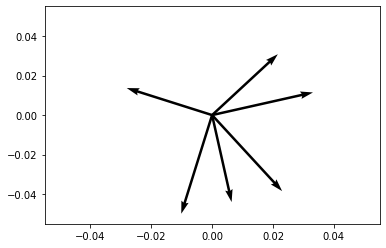

In [10]:
plt.quiver(*np.array([[0] * 6,[0] * 6]), pca.components_.T[:, 0], pca.components_.T[:, 1], scale=2)

### Сжатие других отведений

In [11]:
chest_leads = example[0][:, 6:]
chest_leads.shape

(5000, 6)

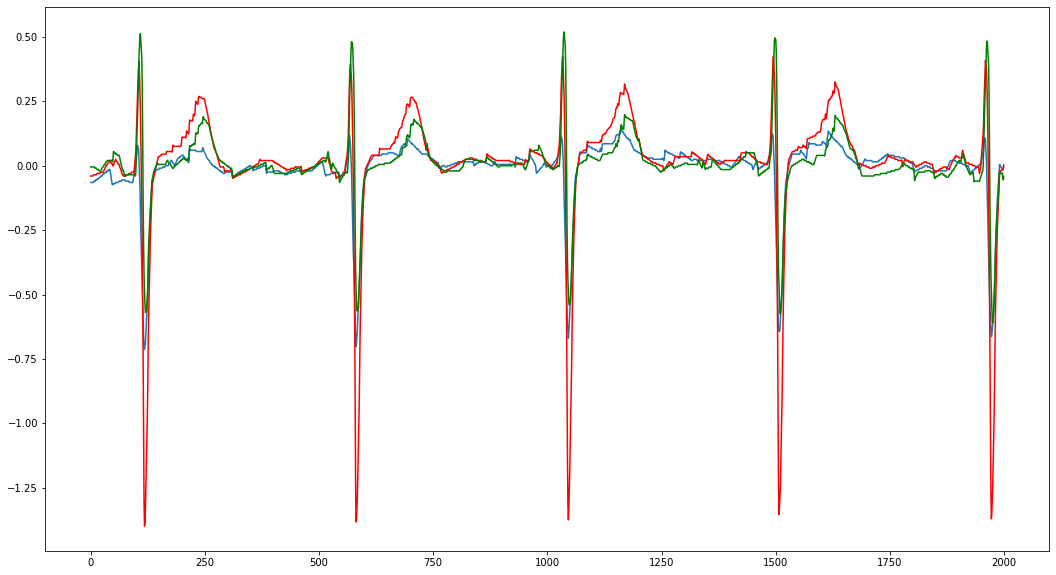

In [12]:
plt.figure(figsize=(18, 10))
plt.plot(range(2000), chest_leads.T[0][:2000])
plt.plot(range(2000), chest_leads.T[1][:2000], color='r')
plt.plot(range(2000), chest_leads.T[2][:2000], color='g')

In [13]:
chest_pca = PCA(n_components=4)
chest_pca.fit(chest_leads)

PCA(n_components=4)

In [14]:
np.sum(chest_pca.explained_variance_ratio_)

0.9962872362882463

In [15]:
def crosscorr(x, y, lag):
    return pd.Series(x).corr(pd.Series(y).shift(lag))

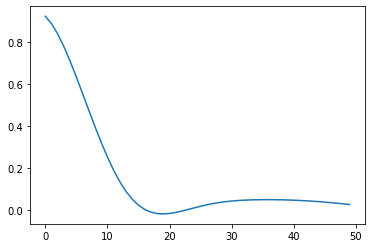

In [16]:
corr = [crosscorr(chest_leads.T[0], chest_leads.T[1], i) for i in range(0, 50)]
plt.plot(range(0, 50), corr)

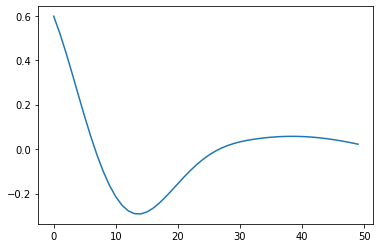

In [17]:
corr = [crosscorr(chest_leads.T[0], chest_leads.T[2], i) for i in range(0, 50)]
plt.plot(range(0, 50), corr)

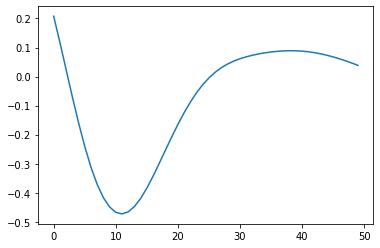

In [18]:
corr = [crosscorr(chest_leads.T[0], chest_leads.T[3], i) for i in range(0, 50)]
plt.plot(range(0, 50), corr)

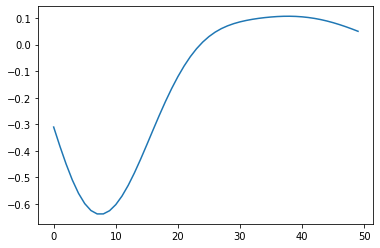

In [19]:
corr = [crosscorr(chest_leads.T[0], chest_leads.T[4], i) for i in range(0, 50)]
plt.plot(range(0, 50), corr)

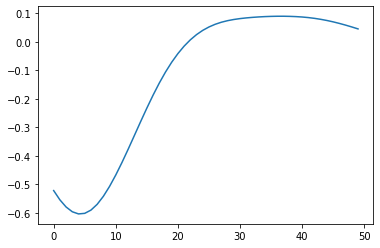

In [20]:
corr = [crosscorr(chest_leads.T[0], chest_leads.T[5], i) for i in range(0, 50)]
plt.plot(range(0, 50), corr)

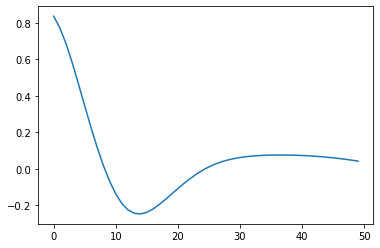

In [21]:
corr = [crosscorr(chest_leads.T[1], chest_leads.T[2], i) for i in range(0, 50)]
plt.plot(range(0, 50), corr)

Как видно, грудные отведения линейно не зависимы а также уровень корелляции с лагом низок

### Удаление шумов

In [22]:
# Чтение данных
path100 = 'plt/records100'
examples = []
for dir_name in tqdm.tqdm(os.listdir(path100)[:]):
    for filename in set(map(lambda s: s.rstrip('.dat').rstrip('.hea'), os.listdir(f'{path100}/{dir_name}'))):
        examples.append(wfdb.rdsamp(f'{path100}/{dir_name}/{filename}'))

100%|██████████| 22/22 [08:00<00:00, 21.83s/it]


In [23]:
infos = [examples[i][1] for i in range(len(examples))]
examples = [examples[i][0] for i in range(len(examples))]

In [43]:
def moving_average(x, m):
    return pd.Series(x).rolling(m).mean().to_numpy()

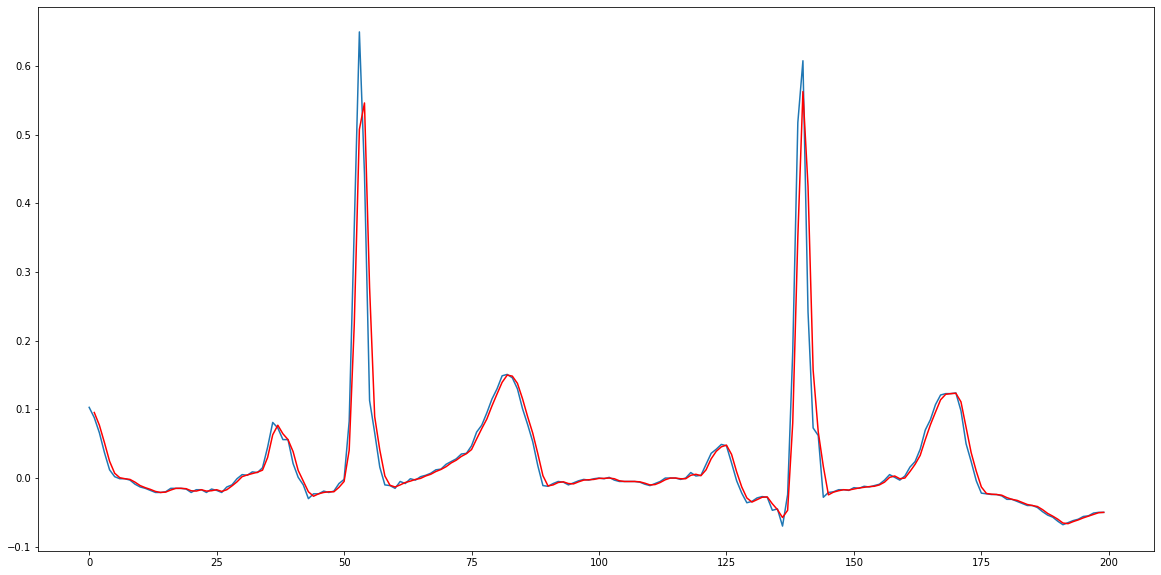

In [45]:
plt.figure(figsize=(20, 10))
plt.plot(examples[0].T[0][:200])
plt.plot(moving_average(examples[0].T[0][:200], 2), color='r')

Проверяем, везде ли одинаковые индексы соответствуют одинаковым отведениям

In [26]:
sig_names_forms = set()
for info in infos:
    sig_names_forms.add(tuple(info['sig_name']))
sig_names_forms

{('I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6')}

Как видно, везде одинаковые индексы соответствуют одинаковым отведениям

Посмотрим какое среднее и разброс в разных отведениях

In [27]:
max_stds = []
min_stds = []
max_means = []
min_means = []
for i, sig_name in enumerate(infos[0]['sig_name']):
    max_stds.append(max([np.std(ex.T[i]) for ex in examples]))
    min_stds.append(min([np.std(ex.T[i]) for ex in examples]))
    max_means.append(max([np.mean(ex.T[i]) for ex in examples]))
    min_means.append(min([np.mean(ex.T[i]) for ex in examples]))
pd.DataFrame(
    [max_stds, min_stds, max_means, min_means], 
    index=['Max std', 'Min std', 'Max mean', 'Min mean'],
    columns=infos[0]['sig_name']
).transpose()

,Max std,Min std,Max mean,Min mean
I,1.119792,0.020332,0.860812,-5.556197
II,1.155264,0.029847,1.680857,-1.255718
III,1.265695,0.016976,5.561592,-1.643592
AVR,1.103834,0.032356,2.775160,-1.114005
AVL,1.068196,0.016626,1.252458,-5.558846
AVF,1.201932,0.020602,2.783237,-1.212937
V1,2.941952,0.021973,5.882733,-0.826611
V2,2.544925,0.038219,1.130133,-1.166814
V3,2.905499,0.039710,0.369889,-1.231775
V4,2.905028,0.029981,0.638397,-9.869941


Вывод графиков со средним и стандартным отклонением

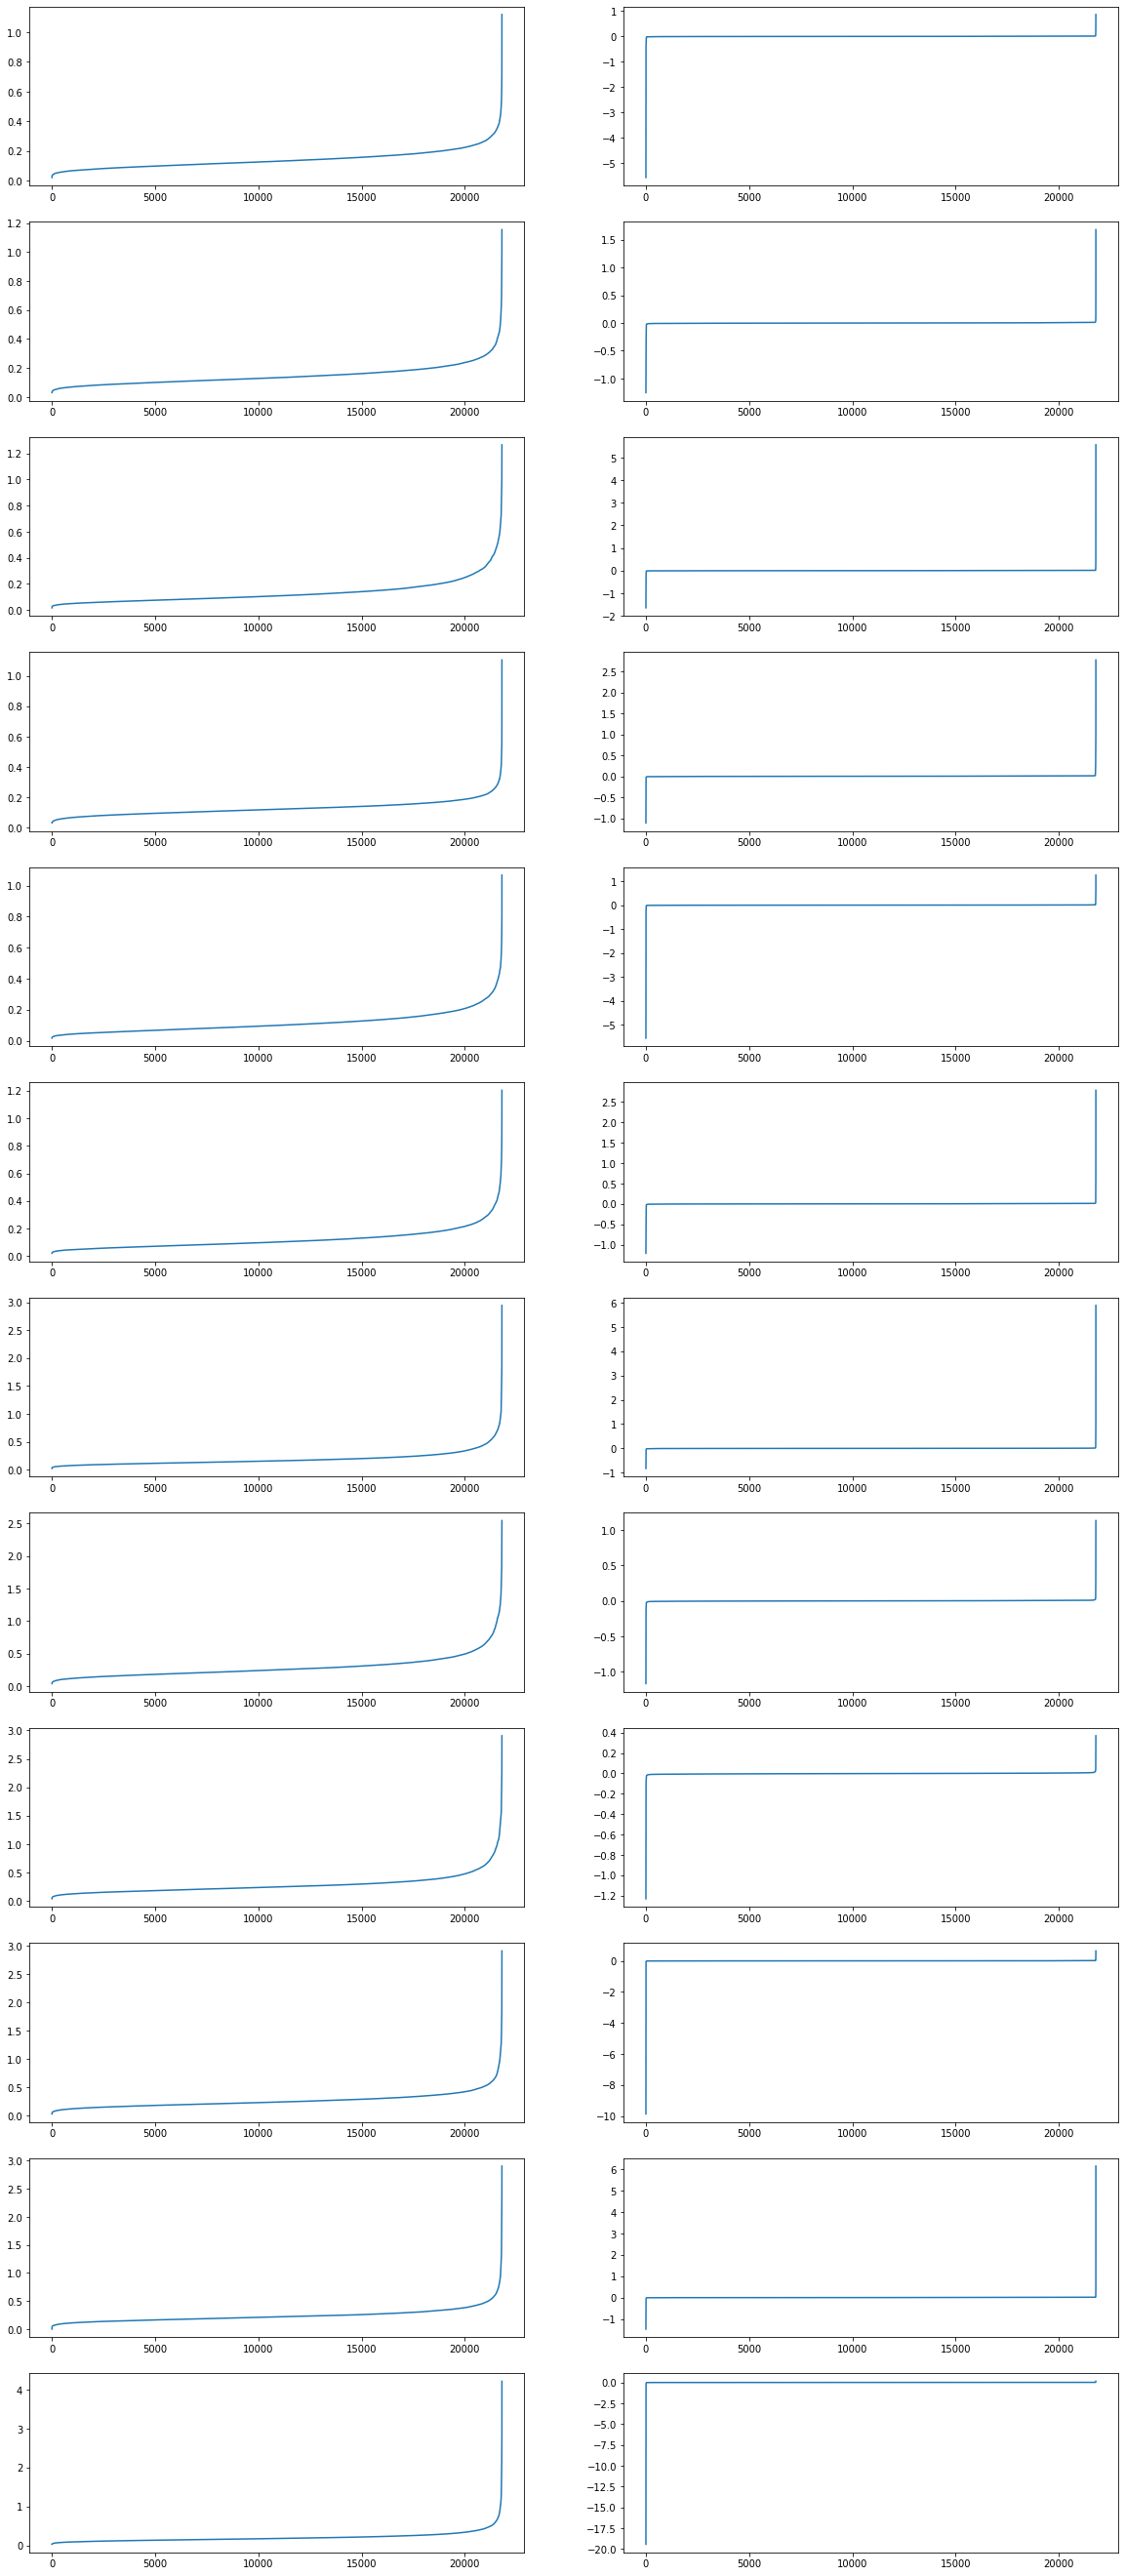

In [28]:
fig = plt.figure(figsize=(20, 48))
for i, sig_name in enumerate(infos[0]['sig_name']):
    ax = fig.add_subplot(12, 2, i * 2 + 1)
    ax.plot(sorted([np.std(ex.T[i]) for ex in examples]))
    ax = fig.add_subplot(12, 2, i * 2 + 2) 
    ax.plot(sorted([np.mean(ex.T[i]) for ex in examples]))

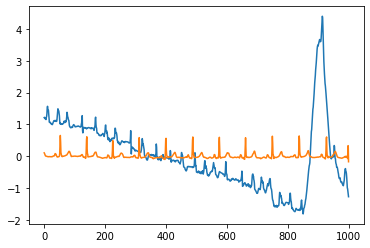

In [29]:
for ex in examples:
    if np.std(ex.T[0]) > 0.8:
        plt.plot(ex.T[0])
        break
for ex in examples:
    if np.std(ex.T[0]) < 0.2:
        plt.plot(ex.T[0])
        break

Вывод: необходимо удалять "Выбросы", примеры:

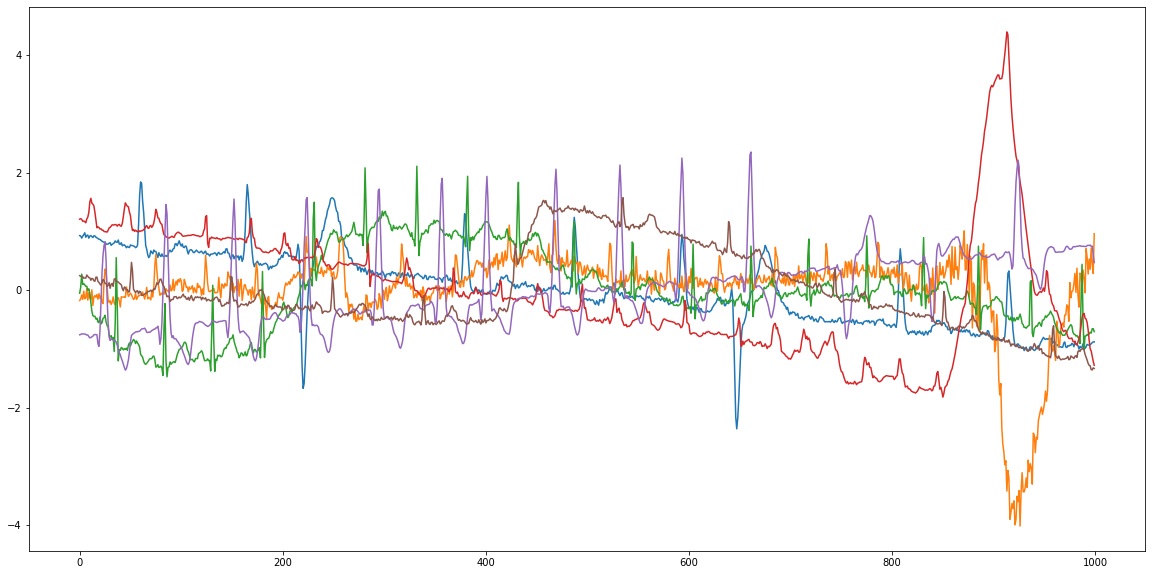

In [30]:
plt.figure(figsize=(20, 10))
cnt = 0
for ex in examples:
    if cnt > 5:
        break
    if 0.6 < np.std(ex.T[0]):
        plt.plot(ex.T[0])
        cnt += 1

Удаление выбросов

In [32]:
def is_acceptable(example, max_std, max_mean_range):
    for series in example.T:
        if not (np.std(series) < max_std and -max_mean_range < np.mean(series) < max_mean_range):
            return False
    return True

In [33]:
print(f'Было объектов {len(examples)}')

Было объектов 21799


In [34]:
filtred_examples = [ex for ex in examples if is_acceptable(ex, 0.65, 0.05)]
print(f'Стало объектов {len(filtred_examples)}')

Стало объектов 20026


Применение moving_average

In [46]:
def moving_average_quality(processed, original):
    return np.abs(processed - original)

def apply_moving_average(example, window):
    ma_processed = np.copy(example)
    for i in range(len(ma_processed.T)):
        ma_processed.T[i] = moving_average(ma_processed.T[i], window)
    return ma_processed

In [47]:
ma_examples = [apply_moving_average(ex, 2) for ex in filtred_examples]